# Challenge - Tweets analysis

![](https://images.unsplash.com/photo-1569285645462-a3f9c6332d56?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80)

This data originally came from Crowdflower's [Data for Everyone library](http://www.crowdflower.com/data-for-everyone).

As the original source says,

> We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked which candidate was mentioned, and what the sentiment was for a given tweet. 

In this exercise, you will use your NLP and ML tools to **predict the sentiment of a tweet**. This is a project where you are free to explore and use the techniques that you know on the given dataset.

Some potential guidelines :
- Be careful to thourougly explore the data and gain insights about it.
- Practice some topic modelling on the text of the tweets.
- Use the NLP tools that you know on the text of each tweet to make predictions about the sentiment of the tweet.
- Try some feature engineering to improve the performance of your model.

The dataset is located in the `input` folder.

In [45]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise
from sklearn.utils import resample

from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models import LsiModel, LdaModel
from pprint import pprint

from textblob import TextBlob

import pyLDAvis
from pyLDAvis import gensim

import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv('Sentiment.csv')
df.head()

,Unnamed: 0,id,candidate,sentiment,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,0,1,No candidate mentioned,Neutral,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,1,2,Scott Walker,Positive,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,2,3,No candidate mentioned,Neutral,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,3,4,No candidate mentioned,Positive,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,4,5,Donald Trump,Positive,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [140]:
## Using Textblob.sentiment

In [47]:
df.isna().sum()
df_use = df[['sentiment', 'text']]

In [48]:
df_use['sentiment'].value_counts('normaliz')

sentiment
Negative    0.612285
Neutral     0.226516
Positive    0.161200
Name: proportion, dtype: float64

In [49]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_use["polarity"] = df_use["text"].apply(pol)
df_use["subjectivity"] = df_use["text"].apply(sub)
df_use.head(7)

,sentiment,text,polarity,subjectivity
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,0.125,0.158333
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,0.450,0.305556
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,0.100,1.000000
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,0.000,0.100000
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,0.000,0.000000
5,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",-0.050,0.311111
6,Negative,RT @warriorwoman91: I liked her and was happy ...,0.700,0.900000


In [50]:
conditions = [
    (df_use['polarity'] < 0),
    (df_use['polarity'] == 0),
    (df_use['polarity'] > 0 )
    ]
values = [-1, 0, 1]

df_use['textblob_class'] = np.select(conditions, values)
df_use.head(10)

,sentiment,text,polarity,subjectivity,textblob_class
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,0.125000,0.158333,1
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,0.450000,0.305556,1
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,0.100000,1.000000,1
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,0.000000,0.100000,0
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,0.000000,0.000000,0
5,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",-0.050000,0.311111,-1
6,Negative,RT @warriorwoman91: I liked her and was happy ...,0.700000,0.900000,1
7,Neutral,Going on #MSNBC Live with @ThomasARoberts arou...,0.136364,0.500000,1
8,Negative,Deer in the headlights RT @lizzwinstead: Ben C...,0.000000,1.000000,0
9,Negative,RT @NancyOsborne180: Last night's debate prove...,0.000000,0.066667,0


In [51]:
conditions = [
    (df_use['sentiment'] == 'Neutral'),
    (df_use['sentiment'] == 'Positive'),
    (df_use['sentiment'] =='Negative')
    ]
values = [0, 1, -1]

df_use['sentiment'] = np.select(conditions, values)
df_use.head(10)

,sentiment,text,polarity,subjectivity,textblob_class
0,0,RT @NancyLeeGrahn: How did everyone feel about...,0.125000,0.158333,1
1,1,RT @ScottWalker: Didn't catch the full #GOPdeb...,0.450000,0.305556,1
2,0,RT @TJMShow: No mention of Tamir Rice and the ...,0.100000,1.000000,1
3,1,RT @RobGeorge: That Carly Fiorina is trending ...,0.000000,0.100000,0
4,1,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,0.000000,0.000000,0
5,1,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",-0.050000,0.311111,-1
6,-1,RT @warriorwoman91: I liked her and was happy ...,0.700000,0.900000,1
7,0,Going on #MSNBC Live with @ThomasARoberts arou...,0.136364,0.500000,1
8,-1,Deer in the headlights RT @lizzwinstead: Ben C...,0.000000,1.000000,0
9,-1,RT @NancyOsborne180: Last night's debate prove...,0.000000,0.066667,0


In [52]:
df_use['textblob_class'].value_counts()

textblob_class
 0    6313
 1    4869
-1    2689
Name: count, dtype: int64

In [53]:
df_use['sentiment'].value_counts()

sentiment
-1    8493
 0    3142
 1    2236
Name: count, dtype: int64

[[0.2492641  0.44577888 0.30495702]
 [0.12762572 0.5436028  0.32877148]
 [0.07647585 0.36627907 0.55724508]]


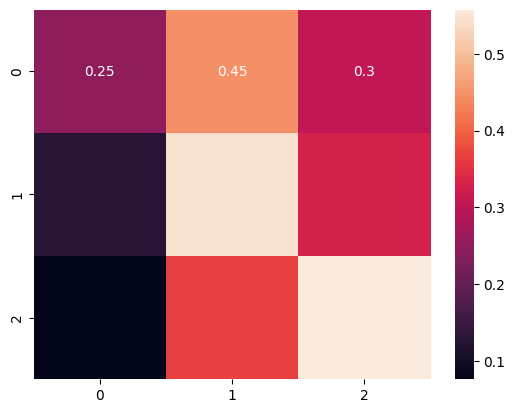

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(df_use["sentiment"], df_use["textblob_class"], normalize='true')
print(conf)
plt.figure()
sns.heatmap(conf, annot=True)
plt.show()

In [55]:
print('Accuracy TextBlob', accuracy_score(df_use["sentiment"], df_use["textblob_class"]))

Accuracy TextBlob 0.3655828707375099


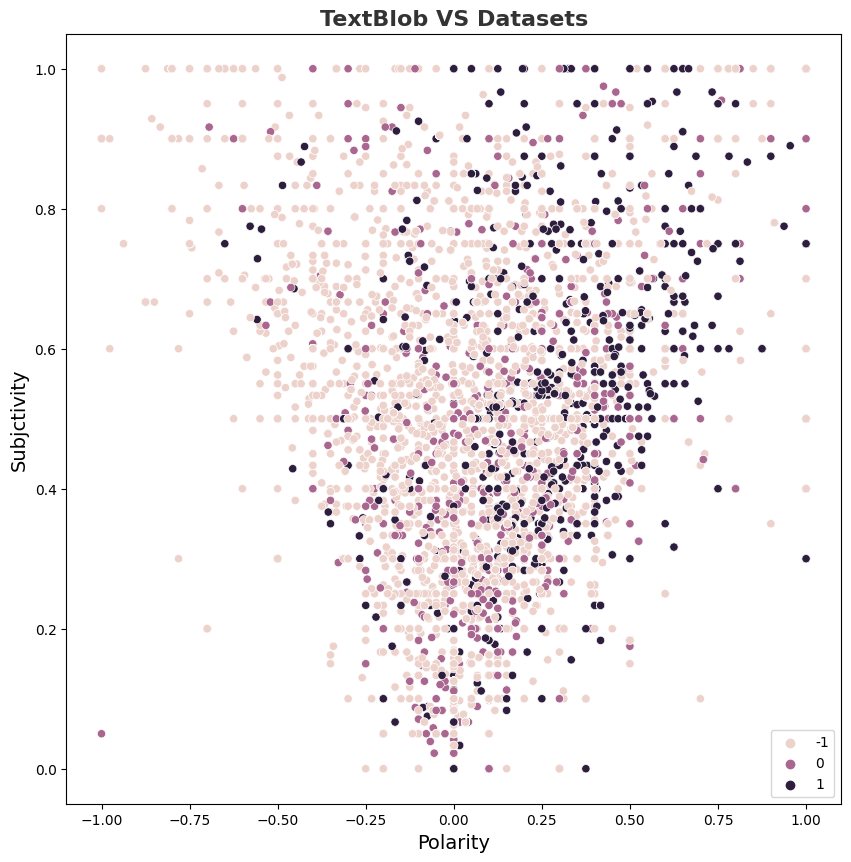

In [56]:
plt.figure(figsize=(10,10))

sns.scatterplot(data = df_use, x =df_use.polarity, y=df_use.subjectivity, hue=df_use.sentiment)

plt.title('TextBlob VS Datasets', fontweight='bold', color = 'black', fontsize='16', alpha=0.8)
plt.xlabel('Polarity', fontsize='14')
plt.ylabel('Subjctivity', fontsize='14')
plt.legend()

plt.show()

In [106]:
##using tfidf and a Logistic Regression 

In [57]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = stopwords.words("english")

def get_wordnet_pos(pos_tag):
    output = np.asarray(pos_tag)
    for i in range(len(pos_tag)):
        if pos_tag[i][1].startswith('J'):
            output[i][1] = wordnet.ADJ
        elif pos_tag[i][1].startswith('V'):
            output[i][1] = wordnet.VERB
        elif pos_tag[i][1].startswith('R'):
            output[i][1] = wordnet.ADV
        else:
            output[i][1] = wordnet.NOUN
    return output

def preprocessing(title, lemma=True, stem=False):
    tokens = word_tokenize(title)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    #tokens = [t for t in tokens if t not in stop_words]
    if stem:
        return [stemmer.stem(t) for t in tokens]
    if lemma:
        tokens_postag = get_wordnet_pos(pos_tag(tokens))
        return [lemmatizer.lemmatize(t, postag) for t, postag in tokens_postag]
        #return [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

In [58]:
df_use['tokens'] = df_use['text'].apply(preprocessing)

In [59]:
#we don't drop stop words because they might help withthe subjectivity/polarity

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_use["tokens"], df_use["sentiment"], test_size=0.2, random_state=0)

In [61]:
vec_t = TfidfVectorizer(lowercase = False, analyzer =lambda x: x)
tfidf_train_t = vec_t.fit_transform(X_train).toarray()
tfidf_test_t = vec_t.transform(X_test).toarray()

In [62]:
vec_c = CountVectorizer(lowercase = False, analyzer =lambda x: x)
tfidf_train_c = vec_c.fit_transform(X_train).toarray()
tfidf_test_c = vec_c.transform(X_test).toarray()

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(tfidf_train_t, y_train)
y_pred_t = lr.predict(tfidf_test_t)

In [ ]:
lr.fit(tfidf_train_c, y_train)
y_pred_c = lr.predict(tfidf_test_c)

In [ ]:
print('Accuracy logistic regression TFIDF:', accuracy_score(y_pred_t, y_test))
print('Accuracy logistic regression BOW:', accuracy_score(y_pred_c, y_test))

In [ ]:
conf_TFIDF = confusion_matrix(y_pred_t, y_test, normalize='true')
print(conf_TFIDF)
plt.figure()
sns.heatmap(conf_BOW, annot=True)
plt.show()

In [ ]:
conf_BOW = confusion_matrix(y_pred_c, y_test, normalize='true')
print(conf_BOW)
plt.figure()
sns.heatmap(conf_BOW, annot=True)
plt.show()